In [1]:
!pip install -U accelerate
!pip install -U transformers
!pip install neptune

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.6/336.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
import os
import random
import json
import shutil
import copy
import numpy as np
import pandas as pd
import requests
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torchvision import models, datasets, transforms
from torchvision.models import ResNet34_Weights
import timm
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments, Trainer
from transformers import ViTModel, ViTConfig, ViTForImageClassification
from transformers import BertForSequenceClassification, BertTokenizer, BertModel
import neptune as neptune
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/My Drive/data_full.zip"

Streaming output truncated to the last 5000 lines.
  inflating: data/images/tshirts_and_tops/9c2e762973994a0ea55b0c8d0ab87006.jpg  
  inflating: __MACOSX/data/images/tshirts_and_tops/._9c2e762973994a0ea55b0c8d0ab87006.jpg  
  inflating: data/images/tshirts_and_tops/af200550922c4e5b8c087427f4ac06f3.jpg  
  inflating: __MACOSX/data/images/tshirts_and_tops/._af200550922c4e5b8c087427f4ac06f3.jpg  
  inflating: data/images/tshirts_and_tops/bc16d95ce3e740bea5ae30bf0e94395b.jpg  
  inflating: __MACOSX/data/images/tshirts_and_tops/._bc16d95ce3e740bea5ae30bf0e94395b.jpg  
  inflating: data/images/tshirts_and_tops/2f3689ae66304edd92a6b3fd2f205a41.jpg  
  inflating: __MACOSX/data/images/tshirts_and_tops/._2f3689ae66304edd92a6b3fd2f205a41.jpg  
  inflating: data/images/tshirts_and_tops/34e2fdb5790a4efaa8a7693eca34a681.jpg  
  inflating: __MACOSX/data/images/tshirts_and_tops/._34e2fdb5790a4efaa8a7693eca34a681.jpg  
  inflating: data/images/tshirts_and_tops/4872aeca51874c608e339eb186fad1e1.jpg  
  i

In [5]:
DEFAULT_RANDOM_SEED = 42

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

# torch random seed
import torch
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# basic + torch
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

In [6]:
seedEverything()

# Load class names from the classes file
with open('data/meta/classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]

# Load train and test splits
with open('data/meta/train.json') as f:
    train_data = json.load(f)
with open('data/meta/test.json') as f:
    test_data = json.load(f)

In [7]:
seedEverything()

train_samples = []
test_samples = []
for cls in classes:
    train_samples.extend([(f'data/images/{x}', x[0:x.find('/')]) for x in train_data[cls]])
    test_samples.extend([(f'data/images/{x}', x[0:x.find('/')]) for x in test_data[cls]])
print(f'Train size: {len(train_samples)}')
print(f'Test size: {len(test_samples)}')
print(train_samples[0:5])

Train size: 99000
Test size: 33000
[('data/images/coats/1d260114f0df489b9de8c5cd81d6f26c.jpg', 'coats'), ('data/images/coats/94a8e251345643e2ba10386f26a42eae.jpg', 'coats'), ('data/images/coats/87d66645ed094890af355c8d099580a2.jpg', 'coats'), ('data/images/coats/ee294abae3d646a8b2afdea3e701eb3a.jpg', 'coats'), ('data/images/coats/0f4515c7013f43558d31dfd3a87541d7.jpg', 'coats')]


In [8]:
model_name = "vit"

In [9]:
seedEverything()

torch.cuda.empty_cache()

transform_vit = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the dataset class with image IDs
class CustomZalandoDataset(torch.utils.data.Dataset):
    def __init__(self, samples, transform=None):
        self.samples = [s for s in samples if os.path.splitext(s[0])[1].lower() in [".jpg", ".jpeg", ".png"]]
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        label_index = classes.index(label)
        image = datasets.folder.default_loader(image_path)
        if self.transform:
            image = self.transform(image)
        image_id = os.path.basename(image_path)
        return image, label_index, image_id

# Initialize the datasets
train_dataset = CustomZalandoDataset(train_samples, transform=transform_vit)
test_dataset = CustomZalandoDataset(test_samples, transform=transform_vit)

# Splitting the dataset into current_train and current_val
total_train_count = len(train_dataset)
val_count = int(total_train_count * 0.1)  # 10% for validation
train_count = total_train_count - val_count
current_train, current_val = torch.utils.data.random_split(train_dataset, [train_count, val_count], generator=torch.Generator().manual_seed(42))

# Data loaders for both subsets
train_loader = torch.utils.data.DataLoader(current_train, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(current_val, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f'Size of the train dataset before the split: {total_train_count}')
print(f'Size of the val dataset: {val_count}')
print(f'Size of the train dataset after the split: {train_count}')
print(f'Size of the test dataset: {len(test_dataset)}')

Size of the train dataset before the split: 98995
Size of the val dataset: 9899
Size of the train dataset after the split: 89096
Size of the test dataset: 33000


In [10]:
seedEverything()

# Shared evaluation function for models
def evaluate_model(model, model_name, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    progress = tqdm(test_loader, desc=f"Evaluating {model_name}", leave=False)

    with torch.no_grad():
        for batch_idx, (inputs, labels, _) in enumerate(progress):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs.logits if model_name == "vit" else outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            if batch_idx % 10 == 0:
                batch_accuracy = (preds == labels).sum().item() / len(labels)
                progress.set_postfix(batch=batch_idx + 1, batch_accuracy=f"{batch_accuracy:.3f}")

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"{model_name} Test Accuracy: {accuracy * 100:.2f}%")

    return accuracy * 100, all_labels, all_preds

In [11]:
seedEverything()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Training ViT
vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=6)
vit_model = vit_model.to(device)

# Load trained weights
model_path = f"{model_name}.pth"
vit_model.load_state_dict(torch.load(model_path, map_location=device))
print(f"Loaded weights from {model_path}")

cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded weights from vit.pth


In [12]:
print("Evaluating ViT...")
accuracy, all_labels, all_preds = evaluate_model(vit_model, model_name, test_loader)

Evaluating ViT...


vit Test Accuracy: 87.66%


In [ ]:
seedEverything()

def fetch_and_display_misclassified_images(all_labels, all_preds, test_samples, classes, true_class, misclassified_as, num_examples=5):
    # Find misclassified samples
    misclassified = [
        (test_samples[i][0], classes[true], classes[pred])
        for i, (true, pred) in enumerate(zip(all_labels, all_preds))
        if classes[true] == true_class and classes[pred] == misclassified_as
    ]

    # Take the first `num_examples` samples
    selected_samples = misclassified[:num_examples]

    # If no misclassified examples were found, return early
    if not selected_samples:
        print(f"No misclassified examples found for '{true_class}' misclassified as '{misclassified_as}'.")
        return []

    # Display each image in a separate figure
    for image_path, true_label, predicted_label in selected_samples:
        image = Image.open(image_path)

        # Create a new figure for each image
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.title(f"True: {true_label}\nPredicted: {predicted_label}", fontsize=12)
        plt.axis("off")
        plt.show()

    return selected_samples

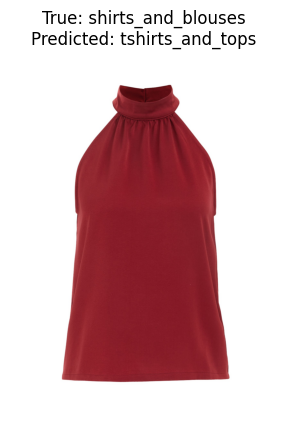

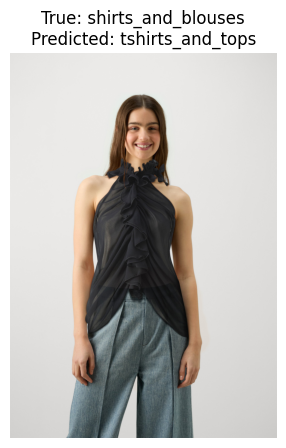

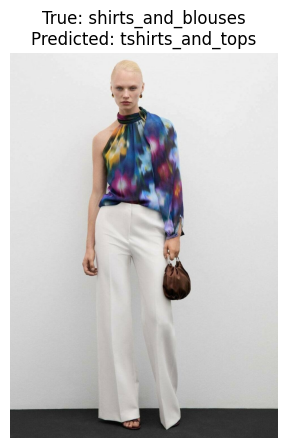

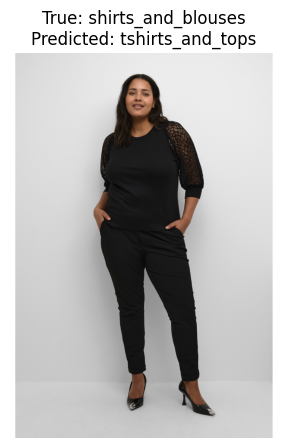

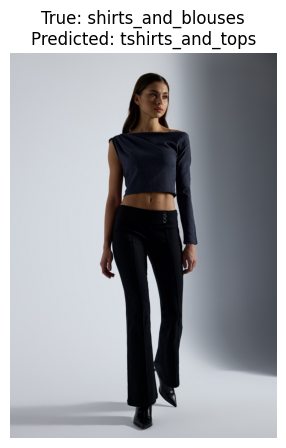

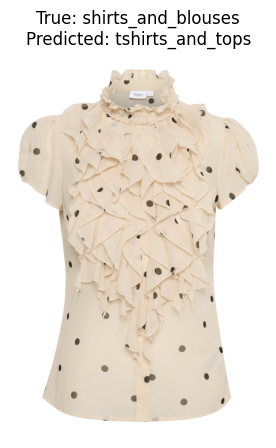

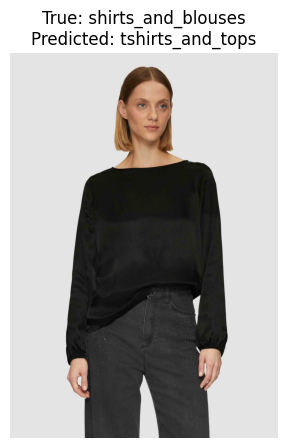

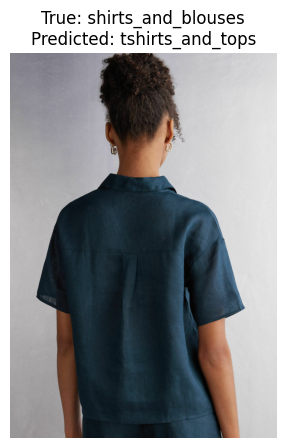

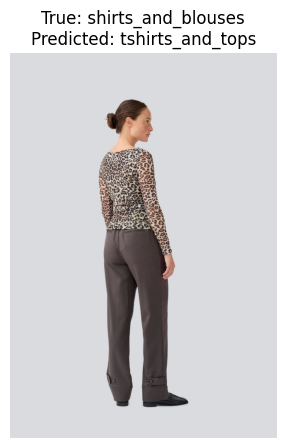

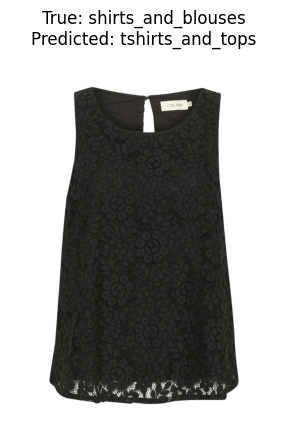

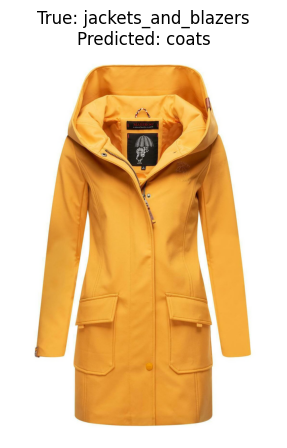

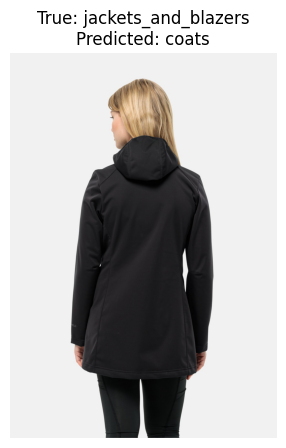

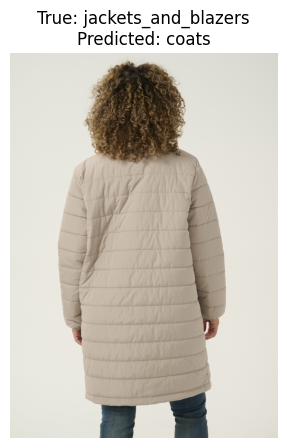

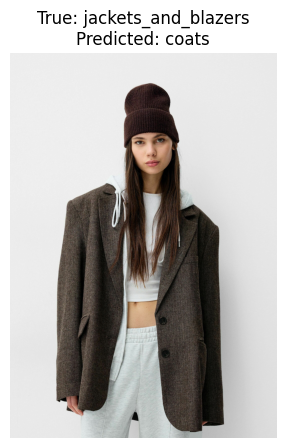

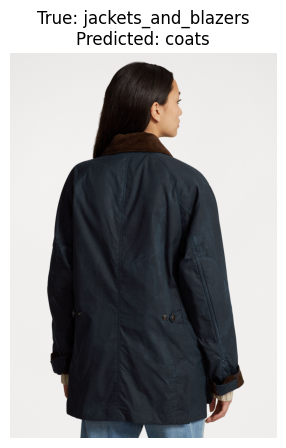

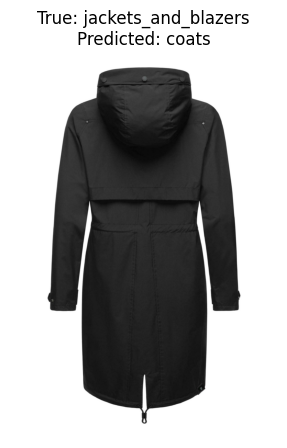

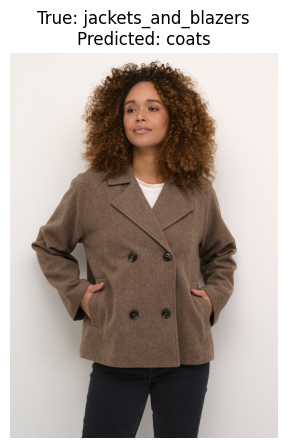

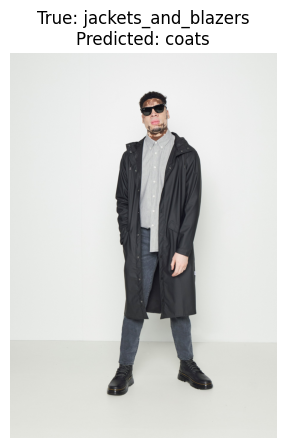

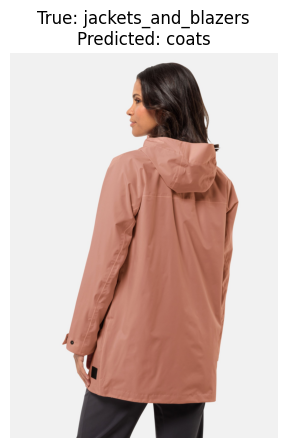

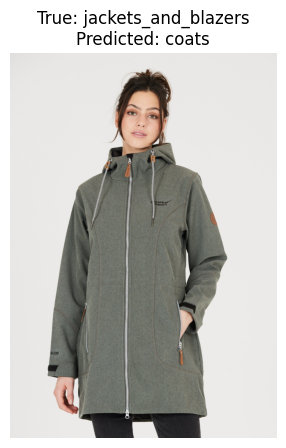

Jackets & Blazers misclassified as Coats: [('data/images/shirts_and_blouses/d44038df81a94f248d66d0f1f656bcea.jpg', 'shirts_and_blouses', 'tshirts_and_tops'), ('data/images/shirts_and_blouses/f57f80b1a04143d7a89f5912ead69b88.jpg', 'shirts_and_blouses', 'tshirts_and_tops'), ('data/images/shirts_and_blouses/8eebebfce90749fd9cac2b7c7946b83d.jpg', 'shirts_and_blouses', 'tshirts_and_tops'), ('data/images/shirts_and_blouses/87f44f13fb1e416a98264e6ed04c2ad7.jpg', 'shirts_and_blouses', 'tshirts_and_tops'), ('data/images/shirts_and_blouses/e913df47fc084940ad61140fa7146ef4.jpg', 'shirts_and_blouses', 'tshirts_and_tops'), ('data/images/shirts_and_blouses/96eb489d38694a1ab95c55eb0463de3e.jpg', 'shirts_and_blouses', 'tshirts_and_tops'), ('data/images/shirts_and_blouses/0c26bdc0810b412698d599ccb35b893f.jpg', 'shirts_and_blouses', 'tshirts_and_tops'), ('data/images/shirts_and_blouses/2167d50a0fd942d28564b338647a487c.jpg', 'shirts_and_blouses', 'tshirts_and_tops'), ('data/images/shirts_and_blouses/6b59

In [14]:
jackets_to_coats = fetch_and_display_misclassified_images(all_labels, all_preds, test_samples, classes,
                                                          "shirts_and_blouses", "tshirts_and_tops", num_examples=10)

shirts_to_tops = fetch_and_display_misclassified_images(all_labels, all_preds, test_samples, classes,
                                                        "jackets_and_blazers", "coats", num_examples=10)

# Print paths of misclassified images
print("Jackets & Blazers misclassified as Coats:", jackets_to_coats)
print("Shirts & Blouses misclassified as T-shirts & Tops:", shirts_to_tops)